In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/dailydialog-multi-turn-dialog-with-intention-and")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dailydialog-multi-turn-dialog-with-intention-and


In [ ]:
import pandas as pd
import kagglehub
import os

# Step 1: Download the dataset
dataset_path = kagglehub.dataset_download("thedevastator/dailydialog-multi-turn-dialog-with-intention-and")
print("Downloaded dataset path:", dataset_path)

# Step 2: Load CSV files manually using the path
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(dataset_path, "validation.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))

# Step 3: Preview the data
print("Train Sample:")
print(train_df.head())

print("\nValidation Sample:")
print(valid_df.head())

print("\nTest Sample:")
print(test_df.head())


Downloaded dataset path: /kaggle/input/dailydialog-multi-turn-dialog-with-intention-and
Train Sample:
                                              dialog                    act  \
0  ['Say , Jim , how about going for a few beers ...  [3 4 2 2 2 3 4 1 3 4]   
1  ['Can you do push-ups ? '\n " Of course I can ...          [2 1 2 2 1 1]   
2  ['Can you study with the radio on ? '\n ' No ,...            [2 1 2 1 1]   
3  ['Are you all right ? '\n ' I will be all righ...              [2 1 1 1]   
4  ['Hey John , nice skates . Are they new ? '\n ...    [2 1 2 1 1 2 1 3 4]   

                 emotion  
0  [0 0 0 0 0 0 4 4 4 4]  
1          [0 0 6 0 0 0]  
2            [0 0 0 0 0]  
3              [0 0 0 0]  
4    [0 0 0 0 0 6 0 6 0]  

Validation Sample:
                                              dialog  \
0  ['Good morning , sir . Is there a bank near he...   
1  ['Good afternoon . This is Michelle Li speakin...   
2  ['What qualifications should a reporter have ?...   
3  ['Hi , good mo

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Lambda
import numpy as np

# Prepare data: Get sample inputs from train_df
texts = train_df['dialog'].astype(str).tolist()[:1000]  # Use fewer for demo

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, padding='post')
vocab_size = len(tokenizer.word_index) + 1

# Custom Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.Wq = Dense(units)
        self.Wk = Dense(units)
        self.Wv = Dense(units)

    def call(self, inputs):
        Q = self.Wq(inputs)
        K = self.Wk(inputs)
        V = self.Wv(inputs)

        scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.units, tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)
        output = tf.matmul(weights, V)
        return output

# Define the model
input_layer = Input(shape=(padded.shape[1],))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)
attention_output = SelfAttention(64)(embedding_layer)

pooled = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention_output)

output_layer = Dense(1, activation='sigmoid')(pooled)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 621)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 621, 64)        │       393,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 621, 64)        │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,529 (1.55 MB)

 Trainable params: 406,529 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


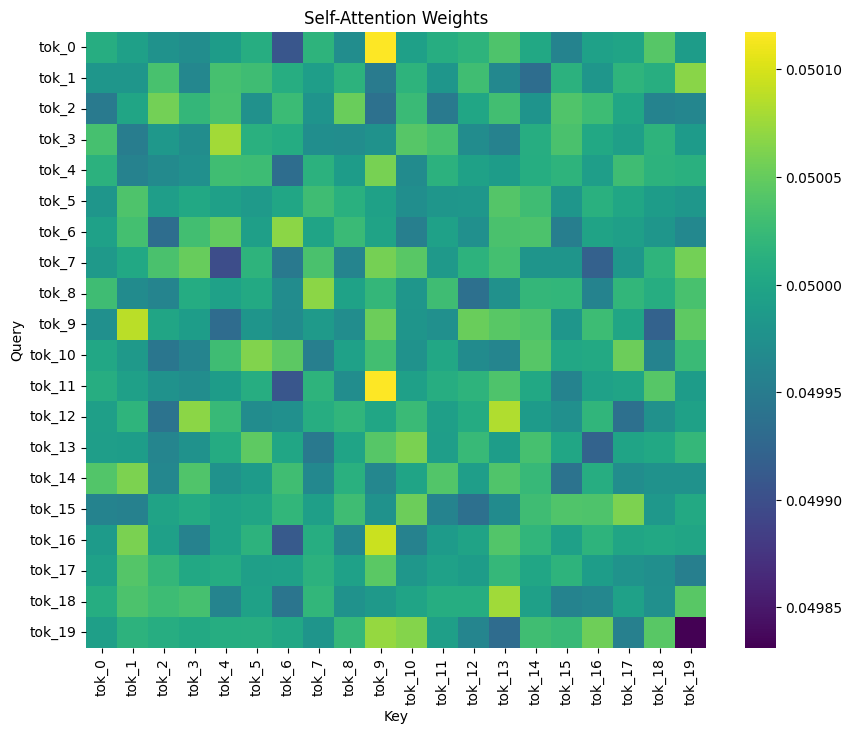

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Embedding, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

MAX_LEN = 20

# 1. Self-Attention Layer (standalone, returns weights)
class SelfAttention(Layer):
    def __init__(self, hidden_size, return_attention=False):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W_q = self.add_weight(shape=(input_shape[-1], self.hidden_size), initializer='glorot_uniform', trainable=True)
        self.W_k = self.add_weight(shape=(input_shape[-1], self.hidden_size), initializer='glorot_uniform', trainable=True)
        self.W_v = self.add_weight(shape=(input_shape[-1], self.hidden_size), initializer='glorot_uniform', trainable=True)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.W_q)
        K = tf.matmul(inputs, self.W_k)
        V = tf.matmul(inputs, self.W_v)

        scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.hidden_size, tf.float32))
        attention_weights = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(attention_weights, V)

        if self.return_attention:
            return context, attention_weights
        return context

# 2. Model Setup
vocab_size = 1000
embedding_dim = 64
seq_len = 20

inputs = Input(shape=(seq_len,))
embedding = Embedding(vocab_size, embedding_dim)(inputs)
attention_layer = SelfAttention(hidden_size=64, return_attention=True)
attention_output, attention_weights = attention_layer(embedding)

from tensorflow.keras.layers import Lambda

pooled = Lambda(lambda x: tf.reduce_mean(x, axis=1))(attention_output)
output = Dense(1, activation='sigmoid')(pooled)


model = Model(inputs=inputs, outputs=[output, attention_weights])
model.compile(optimizer='adam', loss='binary_crossentropy')

# 3. Dummy data
sample_input = np.random.randint(0, vocab_size, size=(1, seq_len))
_ , attention = model.predict(sample_input)

# 4. Attention Visualization
def plot_attention(attention_weights, input_tokens):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights, xticklabels=input_tokens, yticklabels=input_tokens, cmap='viridis')
    plt.title("Self-Attention Weights")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()

input_tokens = [f"tok_{i}" for i in range(seq_len)]
plot_attention(attention[0], input_tokens)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import re

def parse_act(act_str):
    # Add commas between numbers if missing
    act_str = re.sub(r'(?<=\d)\s+(?=\d)', ', ', act_str.strip())
    return eval(act_str)  # now it's safe


# 1. Tokenize dialogs
dialogs = train_df['dialog'].apply(lambda x: ' '.join(eval(x)))  # Convert list-like string to proper string
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(dialogs)
sequences = tokenizer.texts_to_sequences(dialogs)

# 2. Pad sequences to fixed length
MAX_LEN = 50
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# 3. Encode labels (acts or emotions)
label_encoder = LabelEncoder()
# Apply to column and get last act
labels = train_df['act'].apply(lambda x: parse_act(x)[-1])# using last act in sequence

import re

# Clean and convert 'act' column into actual lists of integers
def parse_act_column(act_str):
    act_str = act_str.strip("[]")             # Remove brackets
    act_list = re.split(r'\s+', act_str)      # Split by whitespace
    return list(map(int, act_list))           # Convert to integers

# Apply the function to get list of acts
train_acts = train_df['act'].apply(parse_act_column)

# Get the last act from each list
last_acts = train_acts.apply(lambda x: x[-1])

# Fit the LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(last_acts)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
import tensorflow as tf

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values):
        score = tf.nn.tanh(self.W1(values) + self.W2(values))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# Build model
input_layer = Input(shape=(MAX_LEN,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64)(input_layer)
attention_output = SelfAttention(64)(embedding_layer)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(attention_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 50, 64)         │     1,164,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_3                │ (None, 64)             │         8,385 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,172,805 (4.47 MB)

 Trainable params: 1,172,805 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

**Inference Speed**

In [ ]:
import time

start = time.time()
history = model.fit(padded, labels, epochs=5, batch_size=32)
training_time = time.time() - start
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7775 - loss: 0.6274
Epoch 2/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8030 - loss: 0.5584
Epoch 3/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8168 - loss: 0.4928
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8272 - loss: 0.4609
Epoch 5/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8408 - loss: 0.4065
Training time: 48.34 seconds


In [ ]:

from tensorflow.keras.utils import to_categorical
# Prepare test data
X_test = tokenizer.texts_to_sequences(test_df['dialog'])  # Convert dialogs to sequences
X_test = pad_sequences(X_test, padding='post', maxlen=20)  # Pad the sequences (same as training)

# Label encode the target variable (dialog acts)
y_test_acts = test_df['act'].apply(lambda x: parse_act(x)[-1])
y_test = label_encoder.transform(y_test_acts)  # Encode labels using the label_encoder

# One-hot encode the labels if needed (for categorical cross-entropy loss)
y_test_one_hot = to_categorical(y_test, num_classes=len(label_encoder.classes_))

# Now you can make predictions and calculate accuracy
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.5800


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Example: reference and candidate sentences
references = [["hello", "how", "are", "you"]]  # Reference response (ground truth)
candidates = [["hi", "how", "you"]]  # Predicted response

# Apply smoothing to BLEU score
smooth_fn = SmoothingFunction().method1  # Smoothing method 1 (there are other methods)
bleu = sentence_bleu(references, candidates[0], smoothing_function=smooth_fn)
print(f"BLEU score with smoothing: {bleu:.4f}")


BLEU score with smoothing: 0.0968


In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

# ROUGE score
rouge = Rouge()
scores = rouge.get_scores([' '.join(candidates[0])], [' '.join(references[0])])
print(f"ROUGE score: {scores[0]}")


ROUGE score: {'rouge-1': {'r': 0.5, 'p': 0.6666666666666666, 'f': 0.5714285665306124}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.5, 'p': 0.6666666666666666, 'f': 0.5714285665306124}}


In [ ]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('wordnet')

from nltk.translate import meteor_score

# Example: reference and candidate sentences (tokenized)
references = [["hello", "how", "are", "you"]]  # Reference response (ground truth)
candidates = [["hi", "how", "you"]]  # Predicted response

# METEOR score
meteor = meteor_score.single_meteor_score(references[0], candidates[0])
print(f"METEOR score: {meteor:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


METEOR score: 0.6553


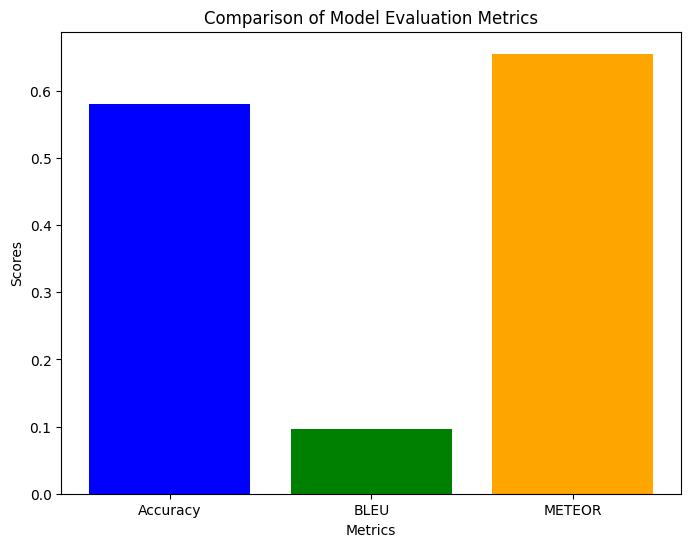

In [ ]:
import matplotlib.pyplot as plt

# Example scores for Accuracy, BLEU, and METEOR
accuracy = 0.5800
bleu = 0.0968
meteor = 0.6553

# Create a list of the metrics and their values
metrics = ['Accuracy', 'BLEU', 'METEOR']
scores = [accuracy, bleu, meteor]

# Plotting the comparison graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'orange'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Evaluation Metrics')

# Display the plot
plt.show()


In [ ]:
import time
import numpy as np

# Assume X_test is your test data and model is already loaded/trained
# You can also select a subset like X_test[:100] if X_test is large

num_samples = 100  # Number of test samples to measure
X_sample = X_test[:num_samples]

# Warm up the model (optional but recommended for consistent results)
_ = model.predict(X_sample[:1])

# Start timing
start_time = time.time()

# Run inference
_ = model.predict(X_sample, batch_size=1, verbose=0)

# End timing
end_time = time.time()

# Calculate average time per sample
total_time = end_time - start_time
avg_inference_time = total_time / num_samples

print(f"Inference time for {num_samples} samples: {total_time:.4f} seconds")
print(f"Average inference time per sample: {avg_inference_time:.6f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Inference time for 100 samples: 1.5274 seconds
Average inference time per sample: 0.015274 seconds
